In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
import scipy.stats as scs

load_dotenv(dotenv_path="../.env")
RAW_DATA_PATH = os.environ.get("RAW_DATA_PATH", "")

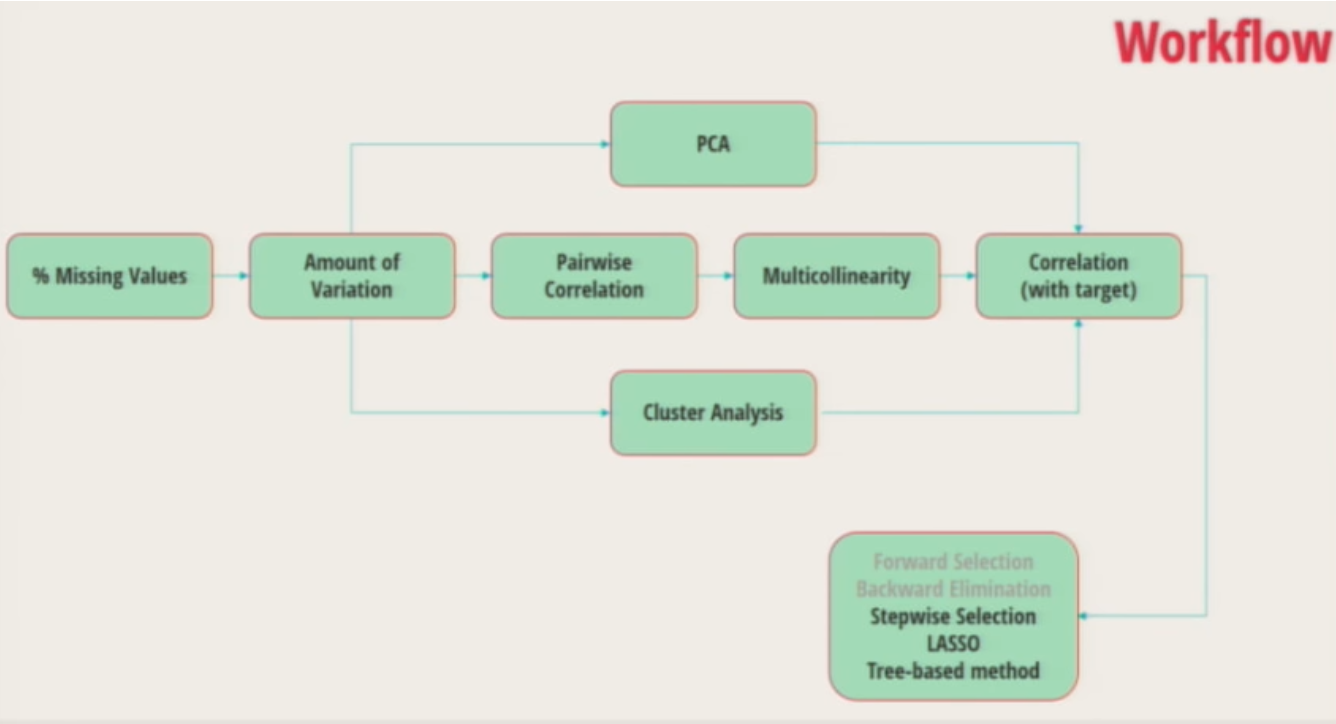

In [302]:
def DataLoad(base_dir, f_name):
    data = pd.read_csv(base_dir + "/" + f_name)

    print(f"Shape of the {f_name.split('.')[0]} data: {data.shape}")
    return data

In [303]:
# load data
submission_data = DataLoad(RAW_DATA_PATH, "sample_submission.csv")
test_data = DataLoad(RAW_DATA_PATH, "test.csv")
train_data = DataLoad(RAW_DATA_PATH, "train.csv")
supplemental_data = DataLoad(RAW_DATA_PATH, "horse.csv")

# join supplemental_data with train_data
supplemental_data["id"] = train_data.shape[0] + \
    test_data.shape[0] + supplemental_data.index

train_data = pd.concat([train_data, supplemental_data], axis=0)
train_data = train_data.reset_index().drop(columns=["index"])

Shape of the sample_submission data: (824, 2)
Shape of the test data: (824, 28)
Shape of the train data: (1235, 29)
Shape of the horse data: (299, 28)


In [304]:
categorical_features = [train_data.dtypes.index[i] for i, feat in enumerate(train_data.dtypes) if feat=="object"]
numerical_features = [feat for feat in train_data.columns if feat not in categorical_features]

# Missing values

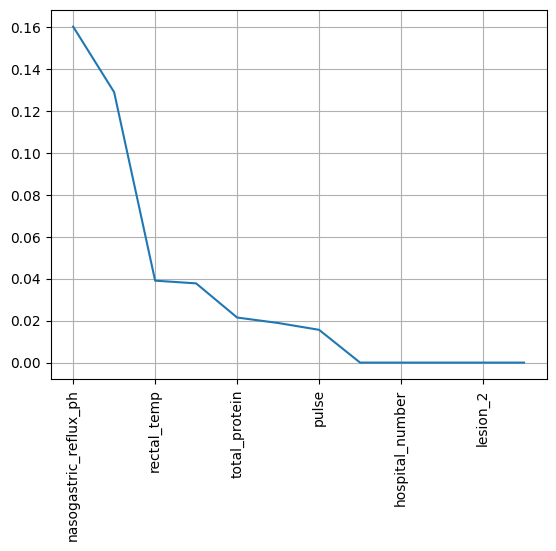

In [305]:
desc = train_data.describe().T
desc["missing %"] = 1 - (desc["count"] / len(train_data))

desc["missing %"].sort_values(ascending = False).plot()
plt.xticks(rotation=90)
plt.grid();

* no > 95 % missing values => no features to discard
* Imputation needs to be done

# Variance Analysis

In [306]:
scaler = preprocessing.MinMaxScaler()
train_data_num_scaled = pd.DataFrame(
    scaler.fit_transform(train_data[numerical_features]),
    columns = train_data[numerical_features].columns)

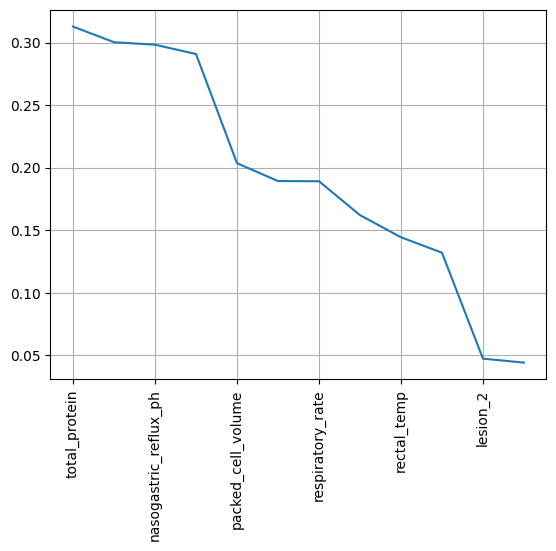

In [307]:
numerical_std_scaled = train_data_num_scaled.std()
numerical_std_scaled.sort_values(ascending = False).plot()
plt.xticks(rotation=90)
plt.grid();

In [308]:
from sklearn.preprocessing import LabelEncoder

cat_data = train_data[categorical_features]
cat_data[pd.isnull(cat_data)]  = 'NaN'

encoder = LabelEncoder()

for col in cat_data.columns:
    cat_data[col] = encoder.fit_transform(cat_data[col])
    

scaler = preprocessing.MinMaxScaler()
train_data_cat_scaled = pd.DataFrame(
    scaler.fit_transform(cat_data),
    columns = cat_data.columns)

C:\Users\Robin Wesselmann\AppData\Local\Temp\ipykernel_5396\2578453351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data[pd.isnull(cat_data)]  = 'NaN'
C:\Users\Robin Wesselmann\AppData\Local\Temp\ipykernel_5396\2578453351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data[pd.isnull(cat_data)]  = 'NaN'
C:\Users\Robin Wesselmann\AppData\Local\Temp\ipykernel_5396\2578453351.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

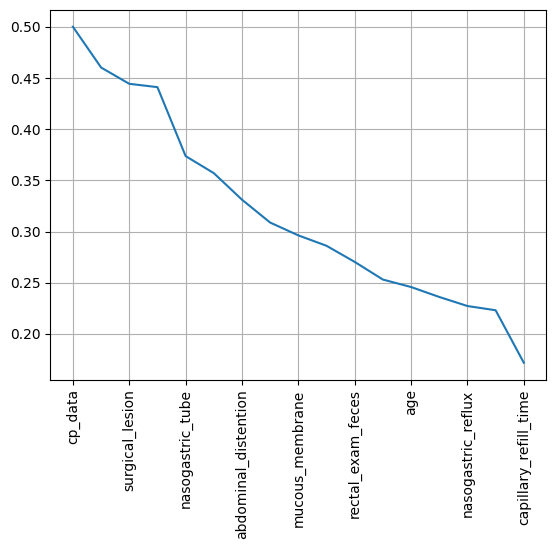

In [309]:
cat_std_scaled = train_data_cat_scaled.std()
cat_std_scaled.sort_values(ascending = False).plot()
plt.xticks(rotation=90)
plt.grid();

In [310]:
dominant_features = {}

for feat in categorical_features:
    dominant_features[feat] = train_data[feat].value_counts(normalize=True).values

In [311]:
pd.DataFrame().from_dict(data=dominant_features, orient="index")

,0,1,2,3,4,5
surgery,0.695567,0.304433,NaN,NaN,NaN,NaN
age,0.935463,0.064537,NaN,NaN,NaN,NaN
temp_of_extremities,0.561501,0.279361,0.102849,0.056289,NaN,NaN
peripheral_pulse,0.588612,0.386477,0.018505,0.006406,NaN,NaN
mucous_membrane,0.232606,0.231241,0.198499,0.160982,0.096180,0.080491
capillary_refill_time,0.682487,0.314840,0.002674,NaN,NaN,NaN
pain,0.340070,0.331010,0.128223,0.112892,0.087108,0.000697
peristalsis,0.538095,0.351701,0.062585,0.046939,0.000680,NaN
abdominal_distention,0.417869,0.282474,0.197251,0.102405,NaN,NaN
nasogastric_tube,0.636296,0.256296,0.107407,NaN,NaN,NaN


# Pairwise Correlation

In [312]:
corrMatrix = train_data[numerical_features].corr()
corr_dict = {}

for col in corrMatrix.columns:
    
    inner_dict = {}
    
    log = False

    for row_no in range(len(corrMatrix.index)):
                        
        curr_corr = corrMatrix[col][row_no]
        
        if (curr_corr == 1.0) and (col == corrMatrix.index[row_no]):
            log = True
                            
        if log:
            inner_dict[corrMatrix.index[row_no]]=curr_corr

        
    corr_dict[col] = inner_dict

C:\Users\Robin Wesselmann\AppData\Local\Temp\ipykernel_5396\3527032196.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_corr = corrMatrix[col][row_no]


In [313]:
df_ls = []

for key in corr_dict.keys():
    for col in corr_dict[key].keys():
        curr_relation = [key, col, corr_dict[key][col], abs(corr_dict[key][col])]
        
        df_ls.append(curr_relation)
        
corr_df = pd.DataFrame(df_ls, columns = ["Feat_1", "Feat_2", "Corr", "Corr abs"])
corr_df = corr_df[corr_df["Feat_1"] != corr_df["Feat_2"]]

In [314]:
corr_df.sort_values(by="Corr abs", ascending=False)

,Feat_1,Feat_2,Corr,Corr abs
52,nasogastric_reflux_ph,total_protein,-0.588581,0.588581
64,total_protein,abdomo_protein,-0.475362,0.475362
36,pulse,packed_cell_volume,0.436590,0.436590
53,nasogastric_reflux_ph,abdomo_protein,0.434775,0.434775
76,lesion_2,lesion_3,0.405214,0.405214
...,...,...,...,...
73,lesion_1,lesion_2,-0.002416,0.002416
32,rectal_temp,lesion_3,0.002119,0.002119
46,respiratory_rate,abdomo_protein,-0.000798,0.000798
40,pulse,lesion_2,-0.000079,0.000079


* all features have a bivariate Correlation of < 65 % and so we don't have any abundantly redundant information included in the variables

# Multicollinearity

In [316]:
corrMatrix.shape

(12, 12)

In [320]:
ct = len(corrMatrix)
condIndexTol = 30
minVarsKeep = 10

if ct > minVarsKeep:
    while True:
        ct -=1
        cols = corrMatrix.keys()
        w, v = np.linalg.eig(corrMatrix)
        w1 = (max(w) / w) ** 0.5
        
        if max(w1) <= condIndexTol or ct == minVarsKeep:
            break
        
        for i, val in enumerate(w):
            if val == min(w):
                for j, vec in enumerate(v[:, i]):
                    if abs(vec) == max(abs((v[:, i]))):
                        mask = np.ones(len(corrMatrix), dtype=bool)
                        for n, col in enumerate(corrMatrix.keys()):
                            mask[n] = n != j
                        
                        corrMatrix = corrMatrix[mask]
                        corrMatrix.pop(cols[j])

In [322]:
w1

array([1.        , 1.08553265, 1.23486179, 1.39046285, 1.48683651,
       1.48145388, 1.58279094, 1.68648609, 2.35387121, 2.14916469,
       1.89339092, 1.93637741])

In [321]:
corrMatrix

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
id,1.000000,0.029107,-0.009059,-0.094580,0.012010,0.000022,-0.115778,0.045545,-0.019360,0.024883,0.063884,0.005601
hospital_number,0.029107,1.000000,0.021959,0.165043,0.121531,0.109276,-0.035770,-0.167728,0.125491,0.054696,-0.007484,-0.014247
rectal_temp,-0.009059,0.021959,1.000000,0.184317,0.145056,0.120317,0.086626,-0.061348,0.040722,0.027986,-0.032740,0.002119
pulse,-0.094580,0.165043,0.184317,1.000000,0.404021,-0.009825,0.436590,-0.016209,0.053777,0.015611,-0.000079,0.043575
respiratory_rate,0.012010,0.121531,0.145056,0.404021,1.000000,0.009872,0.171130,-0.011389,-0.000798,0.046372,-0.011460,0.043053
nasogastric_reflux_ph,0.000022,0.109276,0.120317,-0.009825,0.009872,1.000000,-0.101988,-0.588581,0.434775,0.054855,-0.029539,-0.024327
packed_cell_volume,-0.115778,-0.035770,0.086626,0.436590,0.171130,-0.101988,1.000000,0.129129,-0.038880,-0.079604,-0.015554,0.019652
total_protein,0.045545,-0.167728,-0.061348,-0.016209,-0.011389,-0.588581,0.129129,1.000000,-0.475362,-0.119339,0.106499,0.032502
abdomo_protein,-0.019360,0.125491,0.040722,0.053777,-0.000798,0.434775,-0.038880,-0.475362,1.000000,0.045508,-0.046712,-0.039180
lesion_1,0.024883,0.054696,0.027986,0.015611,0.046372,0.054855,-0.079604,-0.119339,0.045508,1.000000,-0.002416,0.003312


* no multicolinearity between the variables => all condition index < 30

# Correlation with Target

In [330]:
X = train_data[categorical_features].drop("outcome", axis = 1).astype("category")
X = X.apply(lambda x: x.cat.codes)

scaler = preprocessing.MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

y = train_data["outcome"].astype("category")

In [333]:
selection = SelectKBest(score_func=chi2, k = "all")

selection.fit(X_scaled, y)

chi2_result = pd.DataFrame({
    "variable": X_scaled.columns,
    "chi2_stat": selection.scores_,
    "p_value": selection.pvalues_}).sort_values(by="p_value", ascending = True)

chi2_result

,variable,chi2_stat,p_value
1,age,54.812328,1.252144e-12
15,cp_data,36.235857,1.353579e-08
14,surgical_lesion,34.538266,3.163085e-08
13,abdomo_appearance,24.528589,4.717202e-06
7,peristalsis,14.224922,8.148869e-04
0,surgery,13.803937,1.005804e-03
11,rectal_exam_feces,12.061598,2.403573e-03
2,temp_of_extremities,8.412772,1.490012e-02
12,abdomen,8.356199,1.532761e-02
8,abdominal_distention,6.670669,3.560267e-02


In [338]:
categorical_correlation = np.array([])

for feat in categorical_features[:-1]:
    
    cont_table = pd.crosstab(index = train_data[feat], columns = train_data["outcome"])
    X2_result = scs.chi2_contingency(cont_table)[0]
    N = len(train_data)
    degrees_of_freedom = min(cont_table.shape)-1
    result = np.sqrt((X2_result/N)/degrees_of_freedom)
    
    tmp_arr = np.array([feat, np.round(result, 2), degrees_of_freedom])
    
    if len(categorical_correlation)==0:
        categorical_correlation = tmp_arr
    else:
        categorical_correlation = np.vstack([categorical_correlation, tmp_arr])
        
cramers_V = pd.DataFrame(categorical_correlation, columns = ["Features", "Correlation", "df"]).sort_values(by="Correlation", ascending = False)

cramers_V

,Features,Correlation,df
6,pain,0.35,2
14,surgical_lesion,0.29,1
4,mucous_membrane,0.27,2
3,peripheral_pulse,0.26,2
2,temp_of_extremities,0.24,2
8,abdominal_distention,0.24,2
13,abdomo_appearance,0.24,2
7,peristalsis,0.23,2
15,cp_data,0.22,1
5,capillary_refill_time,0.21,2


In [341]:
log_reg = LogisticRegression()



In [362]:
data = pd.concat([train_data[numerical_features], train_data["outcome"]],axis =1)
data.dropna(inplace = True)

X = data[numerical_features]
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data["outcome"].astype("category").cat.codes

In [363]:
model = log_reg.fit(X, y)

In [371]:
import statsmodels.api as sm

logit_model=sm.MNLogit(y_train,sm.add_constant(X_train))
logit_model
result=logit_model.fit()
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

ModuleNotFoundError: No module named 'statsmodels'